# Release Notes

上一个版本：3.1-FE-KeepTheFeaturesAsTheyOriginallyWere

开展一些特征工程，试图提高表现。上一版本得到的结果，成绩是391名。

忙了一天，终于把所有的步骤跑通了。下一步就是做更多的特征工程，如有条件，就调试一下算法。

最后结果发现，xgb效果还行。以后，如有新的FE策略，就用CAT测试效果，看有无提高。最终的结果还是用xgb来弄吧。

本地跑CAT以及测试，最终的结果用xgb来弄吧，如果足够快的话。

---------------------

这里基本上就是没什么用了。不产生任何本notebook所做的datetime特征，性能反倒看上去更好。狗娘养的。

# Setting working directory

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
os.chdir('/content/drive/My Drive/Colab Notebooks/MachineLearningPractice/XiamenIntlBank')

Go to this place for original dataset: 

`'/content/drive/My Drive/Colab Notebooks/MachineLearningPractice/FinanceRiskControl/originalDataset'`

In [ ]:
## 安装catboost和lightgbm。
## catboost耗费显存极大，但是飞快；lightgbm好像不是那么的方便，gpu使用不起来。
!pip install catboost
# !pip uninstall lightgbm
# !pip install lightgbm --install-option=--gpu --install-option="--opencl-include-dir=/usr/local/cuda/include/" --install-option="--opencl-library=/usr/local/cuda/lib64/libOpenCL.so"

# Importing libraries and load datasets

In [2]:
# !pip install catboost

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import tqdm
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.preprocessing import MinMaxScaler
import xgboost as xgb
import lightgbm as lgb
from catboost import CatBoostRegressor, CatBoostClassifier
import warnings
from sklearn.model_selection import StratifiedKFold, KFold
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, log_loss, cohen_kappa_score
# import tqdm
from collections import Counter, defaultdict
import tensorflow as tf
import random
import featuretools
warnings.filterwarnings('ignore')

# Rudimentary processing

Like encoding some object type data

## Load dataset

In [2]:
data_train = pd.read_csv('preprocessedData/quarter3_merged-validLabels.csv')
data_test_a = pd.read_csv('preprocessedData/quarter1_merged-validUsers.csv')

## Delete the cols that have too many nulls

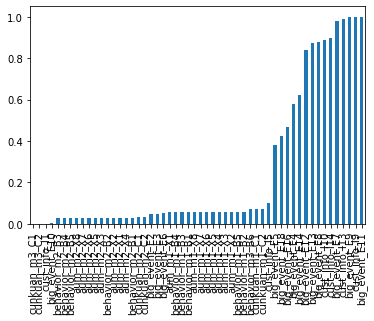

In [3]:
# nan可视化
def seeWhichColumnsHaveMissingValues(data_train): 
    missing = data_train.isnull().sum()/len(data_train)
    missing = missing[missing > 0]
    missing.sort_values(inplace=True)
#     print((missing))
    missing.plot.bar()
seeWhichColumnsHaveMissingValues(data_train)

In [4]:
def seeWhichColumnsHaveMissingValuesMoreThanAThreshold(data_train, threshold): 
    missing = data_train.isnull().sum()/len(data_train)
    missing = missing[missing > threshold]
    missing.sort_values(inplace=True)
    return list(missing.index)
colsThatHaveTooManyNull = seeWhichColumnsHaveMissingValuesMoreThanAThreshold(data_train, 0.15)
print(colsThatHaveTooManyNull)

['big_event_E5', 'big_event_E18', 'big_event_E16', 'big_event_E4', 'big_event_E14', 'big_event_E12', 'big_event_E13', 'big_event_E8', 'cust_info_I10', 'cust_info_I14', 'big_event_E7', 'cust_info_I13', 'big_event_E9', 'big_event_E11', 'cust_info_I9']


上述的列，空值太多(多于15%)，有可能会影响结果，故先放弃。

注意，如果你训练集这样搞了，那么你测试集就得删掉一样的列，不论测试集相应的列有多少空值。

In [5]:
len(data_train.columns)

87

In [6]:
len(data_test_a.columns)

86

In [7]:
data_train = data_train.drop(colsThatHaveTooManyNull, axis=1)
data_test_a = data_test_a.drop(colsThatHaveTooManyNull, axis=1)

## Classify the features into multiple groups

In [8]:
id_col = ["cust_no"]

In [9]:
numerical_fea = list(data_train.select_dtypes(exclude=['object']).columns)
object_fea = list(filter(lambda x: x not in numerical_fea,list(data_train.columns)))
label = 'label'
numerical_fea.remove(label)

In [10]:
## 过滤类别较少的和较多的列
def get_numerical_serial_fea(data,feas):
    numerical_serial_fea = []
    numerical_noserial_fea = []
    for fea in feas:
        temp = data[fea].nunique()
        if temp <= 10:
            numerical_noserial_fea.append(fea)
            continue
        numerical_serial_fea.append(fea)
    return numerical_serial_fea,numerical_noserial_fea
    
numerical_serial_fea,numerical_categorical_fea = get_numerical_serial_fea(data_train,numerical_fea)
print(numerical_serial_fea)
print(numerical_categorical_fea)

['aum_m1_X1', 'aum_m1_X2', 'aum_m1_X3', 'aum_m1_X4', 'aum_m1_X5', 'aum_m1_X6', 'aum_m1_X7', 'aum_m1_X8', 'aum_m2_X1', 'aum_m2_X2', 'aum_m2_X3', 'aum_m2_X4', 'aum_m2_X5', 'aum_m2_X6', 'aum_m2_X7', 'aum_m2_X8', 'aum_m3_X1', 'aum_m3_X2', 'aum_m3_X3', 'aum_m3_X4', 'aum_m3_X5', 'aum_m3_X6', 'aum_m3_X7', 'aum_m3_X8', 'behavior_m1_B1', 'behavior_m1_B2', 'behavior_m1_B3', 'behavior_m1_B4', 'behavior_m1_B5', 'behavior_m2_B1', 'behavior_m2_B2', 'behavior_m2_B3', 'behavior_m2_B4', 'behavior_m2_B5', 'behavior_m3_B1', 'behavior_m3_B2', 'behavior_m3_B3', 'behavior_m3_B4', 'behavior_m3_B5', 'behavior_m3_B7', 'big_event_E15', 'big_event_E17', 'cunkuan_m1_C1', 'cunkuan_m1_C2', 'cunkuan_m2_C1', 'cunkuan_m2_C2', 'cunkuan_m3_C1', 'cunkuan_m3_C2', 'cust_info_I2', 'cust_info_I11']
['cust_info_I4', 'cust_info_I6', 'cust_info_I7', 'cust_info_I15', 'cust_info_I16', 'cust_info_I17', 'cust_info_I18', 'cust_info_I19', 'cust_info_I20']


`big_event_E11, cust_info_I7, cust_info_I9` from numerical_categorical_fea, 类别太少，没有意义。

In [11]:
# numerical_categorical_fea.remove("big_event_E11")
numerical_categorical_fea.remove("cust_info_I7")
# numerical_categorical_fea.remove("cust_info_I9")

In [12]:
data_train.drop(["cust_info_I7"], axis = 1, inplace=True)
data_test_a.drop(["cust_info_I7"], axis = 1, inplace=True)

找日期：所有在`object_fea`里面的`big_event_xx`和`behavior_m3_B6` 是时间类型的。

In [13]:
date_fea = []
for fea in object_fea:
    if "big_event" in fea or "behavior" in fea:
        date_fea.append(fea)
print(date_fea)

['behavior_m3_B6', 'big_event_E1', 'big_event_E2', 'big_event_E3', 'big_event_E6', 'big_event_E10']


找其他类型的列

In [14]:
object_categorical_fea = []
for fea in object_fea:
    if fea not in date_fea and fea not in id_col:
        object_categorical_fea.append(fea)
print(object_categorical_fea)

['cust_info_I1', 'cust_info_I3', 'cust_info_I5', 'cust_info_I8', 'cust_info_I12']


In [15]:
total_list = sorted(list(data_train.columns))

In [16]:
id_col

['cust_no']

In [17]:
print(numerical_serial_fea)

['aum_m1_X1', 'aum_m1_X2', 'aum_m1_X3', 'aum_m1_X4', 'aum_m1_X5', 'aum_m1_X6', 'aum_m1_X7', 'aum_m1_X8', 'aum_m2_X1', 'aum_m2_X2', 'aum_m2_X3', 'aum_m2_X4', 'aum_m2_X5', 'aum_m2_X6', 'aum_m2_X7', 'aum_m2_X8', 'aum_m3_X1', 'aum_m3_X2', 'aum_m3_X3', 'aum_m3_X4', 'aum_m3_X5', 'aum_m3_X6', 'aum_m3_X7', 'aum_m3_X8', 'behavior_m1_B1', 'behavior_m1_B2', 'behavior_m1_B3', 'behavior_m1_B4', 'behavior_m1_B5', 'behavior_m2_B1', 'behavior_m2_B2', 'behavior_m2_B3', 'behavior_m2_B4', 'behavior_m2_B5', 'behavior_m3_B1', 'behavior_m3_B2', 'behavior_m3_B3', 'behavior_m3_B4', 'behavior_m3_B5', 'behavior_m3_B7', 'big_event_E15', 'big_event_E17', 'cunkuan_m1_C1', 'cunkuan_m1_C2', 'cunkuan_m2_C1', 'cunkuan_m2_C2', 'cunkuan_m3_C1', 'cunkuan_m3_C2', 'cust_info_I2', 'cust_info_I11']


In [18]:
print(numerical_categorical_fea)

['cust_info_I4', 'cust_info_I6', 'cust_info_I15', 'cust_info_I16', 'cust_info_I17', 'cust_info_I18', 'cust_info_I19', 'cust_info_I20']


In [19]:
print(date_fea)

['behavior_m3_B6', 'big_event_E1', 'big_event_E2', 'big_event_E3', 'big_event_E6', 'big_event_E10']


In [20]:
print(object_categorical_fea)

['cust_info_I1', 'cust_info_I3', 'cust_info_I5', 'cust_info_I8', 'cust_info_I12']


`object_categorical_fea` 还能继续分，有的是有等级的，有的没有等级（这些没有等级的，可以考虑进行那个啥，onehot）

下面的代码用来检查有没有特征被漏掉。

In [21]:
new_cates = numerical_categorical_fea + numerical_serial_fea + date_fea + object_categorical_fea 

In [22]:
set(total_list) - set(new_cates)

{'cust_no', 'label'}

如果空留label、ID，则无特征被遗漏。

## Change `object_categorical_fea` 

这里面也有一些类是可以进行序列化的，比如`cust_info_I3`用户的等级, `cust_info_I10`学历, `cust_info_I14`官阶，这几个都可以序列化。

鉴于这个notebook只做最原生态的处理，所以就将之简单归类了。

In [23]:
object_categorical_fea

['cust_info_I1',
 'cust_info_I3',
 'cust_info_I5',
 'cust_info_I8',
 'cust_info_I12']

对他们进行普通分类，最普通的分类，就是将他们编码为数字。不搞dummy操作。

In [24]:
def mapTheValue(data, fea, dic):
    """
    data_train is the dataset. 
    fea is the target feature. 
    dic is the mapping dictionary. 
    """
    data[fea] = data[fea].apply(lambda x: dic.get(x, -1)) 


## 这两个特征，是暗含了顺序
for dt in [data_train, data_test_a]: 
    mapTheValue(dt, "cust_info_I3", {
        "普通客户": 0, 
        "黄金": 1,
        "白金": 2,
        "钻石": 3,
    })
    
for col in tqdm.tqdm(["cust_info_I1", 'cust_info_I5', 'cust_info_I8', 'cust_info_I12']): 
    le = LabelEncoder()
    le.fit(list(data_train[col].astype(str).values) + list(data_test_a[col].astype(str).values))
    data_train[col] = le.transform(list(data_train[col].astype(str).values))
    data_test_a[col] = le.transform(list(data_test_a[col].astype(str).values))

100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.00it/s]


# Feature Generation

利用 https://zhuanlan.zhihu.com/p/26444240 介绍的方法开展特征合成：

```
median(N1)_by(C1)  \\ 中位数
mean(N1)_by(C1)  \\ 算术平均数
mode(N1)_by(C1)  \\ 众数
min(N1)_by(C1)  \\ 最小值
max(N1)_by(C1)  \\ 最大值
std(N1)_by(C1)  \\ 标准差
var(N1)_by(C1)  \\ 方差
freq(C2)_by(C1)  \\ 频数

freq(C1) \\这个不需要groupby也有意义
```

上述只是一种思路。

In [25]:
# data_train.to_csv("preprocessedData/data_train-1129-a_a_a_b_b_a_x_x.csv", index=False)
# data_test_a.to_csv("preprocessedData/data_test_a-1129-a_a_a_b_b_a_x_x.csv", index=False)

In [26]:
# data_train = pd.read_csv("preprocessedData/data_train-1129-a_a_a_b_b_a_x_x.csv")
# data_test_a = pd.read_csv("preprocessedData/data_test_a-1129-a_a_a_b_b_a_x_x.csv")

## Change `date_fea`


In [27]:
date_fea

['behavior_m3_B6',
 'big_event_E1',
 'big_event_E2',
 'big_event_E3',
 'big_event_E6',
 'big_event_E10']

把日期拆开，拆成年，月，日

新特征isweekend，要注意，是分类特征，考虑加入分类

In [28]:
for fea in [ "behavior_m3_B6",  
            'big_event_E1',
             'big_event_E2',
             'big_event_E3',
             'big_event_E6',
             'big_event_E10']:   
    data_train[fea] = data_train[fea].astype(str)
    data_test_a[fea] = data_test_a[fea].astype(str)
    
    for data in [data_train, data_test_a]:
        if fea in ["behavior_m3_B6"]: ## 这个列有时分秒，不只有日期。
            data[fea + "_DT"] = pd.to_datetime(data[fea],format = '%Y-%m-%d %H:%M:%S')
        else: ## 这些列，只有日期。
            data[fea + "_DT"] = pd.to_datetime(data[fea],format = '%Y-%m-%d')
        ## 
        data[fea + "_Weekday"] = featuretools.primitives.Weekday()(data[fea + "_DT"])
        ## 
        data[fea + "_IsWeekend"] = featuretools.primitives.IsWeekend()(data[fea + "_DT"])
        data[fea + "_IsWeekend"] = data[fea + "_IsWeekend"].map({True: 1, False: 0})
        ## 
        data[fea + "_Year"] = featuretools.primitives.Year()(data[fea + "_DT"])
        ## 
        data[fea + "_Month"] = featuretools.primitives.Month()(data[fea + "_DT"])
        ## 
        data[fea + "_Week"] = featuretools.primitives.Week()(data[fea + "_DT"])
        ## 
        data[fea + "_Day"] = featuretools.primitives.Day()(data[fea + "_DT"])
        ## 
        data[fea + "_Hour"] = featuretools.primitives.Hour()(data[fea + "_DT"])

# data_train["behavior_m3_B6_weekday"]

`behavior_m3_B6` 是最近一次交易时间，在3，6，9，12月才有这条记录。那么我们就用这个来计算它和其他日期之间差的天数呗。

In [63]:
def calculateDateVariance(x):
    hehe = x[0] - x[1]
    return hehe.days
#     print(type(hehe))
    
for fea in ['big_event_E1',
             'big_event_E2',
             'big_event_E3',
             'big_event_E6',
             'big_event_E10']:
    print("behavior_m3_B6-{}".format(fea))
    data_train["behavior_m3_B6-{}".format(fea)] = (data_train["behavior_m3_B6_DT"] - data_train[fea + "_DT"]).dt.days
    data_test_a["behavior_m3_B6-{}".format(fea)] = (data_test_a["behavior_m3_B6_DT"] - data_test_a[fea + "_DT"]).dt.days
#     data_train["behavior_m3_B6-{}".format(fea)] = data_train[["behavior_m3_B6_DT", fea + "_DT"]].apply(calculateDateVariance) #.dt.days
#     data_test_a["behavior_m3_B6-{}".format(fea)] = data_test_a[["behavior_m3_B6_DT", fea + "_DT"]].apply(lambda x: x[0] - x[1]).dt.days

behavior_m3_B6-big_event_E1
behavior_m3_B6-big_event_E2
behavior_m3_B6-big_event_E3
behavior_m3_B6-big_event_E6
behavior_m3_B6-big_event_E10


还可以计算`E6, E10` 与`E1, E2, E3`之间的差值。

In [64]:
for x_lst_date in ["big_event_E6", "big_event_E10"]: ## 这些特征理论上是更晚的，我要让他们减去xx开户日期
    for init_date in ["big_event_E1", "big_event_E2", "big_event_E3"]:
        print("{}-{}".format(x_lst_date, init_date))
        data_train["{}-{}".format(x_lst_date, init_date)] = (data_train[x_lst_date + "_DT"] - data_train[init_date + "_DT"]).dt.days
        data_test_a["{}-{}".format(x_lst_date, init_date)] = (data_test_a[x_lst_date + "_DT"] - data_test_a[init_date + "_DT"]).dt.days

big_event_E6-big_event_E1
big_event_E6-big_event_E2
big_event_E6-big_event_E3
big_event_E10-big_event_E1
big_event_E10-big_event_E2
big_event_E10-big_event_E3


注意，date特征和date_DT类型的特征，在入模之前必须要处理成数字才行。

最普通，直接将日期改为距离最早日期多少天。

In [66]:
for fea in [ "behavior_m3_B6",  
            'big_event_E1',
             'big_event_E2',
             'big_event_E3',
             'big_event_E6',
             'big_event_E10']:   
    data_train[fea] = data_train[fea].astype(str)
    data_test_a[fea] = data_test_a[fea].astype(str)
    
    if fea in ["behavior_m3_B6"]: ## 这个列有时分秒，不只有日期。
        startdate = datetime.datetime.strptime(
            min(
                str(data_train[fea].min(skipna = True)), str(data_test_a[fea].min(skipna = True))
            ),
            '%Y-%m-%d %H:%M:%S'
        )
        for data in [data_train, data_test_a]:
            data[fea] = pd.to_datetime(data[fea],format = '%Y-%m-%d %H:%M:%S')
            data[fea] = data[fea].apply(lambda x: x-startdate).dt.days ## 这里或许有潜力可挖，比如，换成秒，分钟啊什么的。
    else: ## 这些列，只有日期。
        startdate = datetime.datetime.strptime(
            min(
                str(data_train[fea].min(skipna = True)), str(data_test_a[fea].min(skipna = True))
            ),
            '%Y-%m-%d'
        )
        for data in [data_train, data_test_a]:
            data[fea] = pd.to_datetime(data[fea],format='%Y-%m-%d')
            data[fea] = data[fea].apply(lambda x: x-startdate).dt.days

删掉date_fea_DT类型的

In [67]:
data_train.drop([fea + "_DT" for fea in date_fea], axis = 1, inplace = True)
data_test_a.drop([fea + "_DT" for fea in date_fea], axis = 1, inplace = True)

# Delete the features that will not be used to fit the model

No `xx_outliers` features, no labels, no original dates. 

In [68]:
features = [f for f in data_train.columns if f not in ["cust_no", "label"] and '_outliers' not in f]
y_train = data_train['label'].map({-1: 0, 0: 1, 1: 2})
x_train = data_train[features]
x_test = data_test_a[features]

In [32]:
# x_train = x_train.head(1000)
# x_test = x_test.head(1000)
# y_train = y_train.head(1000)

# Last data processing

~~可以再填充一轮na，然后做一下什么归一化~~ 

看上去不填充，效果好些。

In [33]:
# x_train.fillna(method='ffill', inplace=True)
# x_test.fillna(method='ffill', inplace=True)

In [ ]:
# x_train["aum_m1_X1"].value_counts()

In [69]:
x_train = x_train.apply(lambda x: (x - np.min(x)) / (np.max(x) - np.min(x)))
x_test = x_test.apply(lambda x: (x - np.min(x)) / (np.max(x) - np.min(x)))

In [70]:
x_train.shape

(69126, 122)

# Save preprocessed data if necessary

In [46]:
# x_train.to_csv("preprocessedData/x_train-1129-A_A_A_B_B_A_F_B.csv", index=False)
# x_test.to_csv("preprocessedData/x_test-1129-A_A_A_B_B_A_F_B.csv", index=False)
# y_train.to_csv("preprocessedData/y_train-1129-A_A_A_B_B_A_F_B.csv", index=False)

# Load preprocessed data if applicable

In [47]:
# x_train = pd.read_csv("preprocessedData/x_train-1129-A_A_A_B_B_A_F_B.csv")
# x_test = pd.read_csv("preprocessedData/x_test-1129-A_A_A_B_B_A_F_B.csv")
# y_train = pd.read_csv("preprocessedData/y_train-1129-A_A_A_B_B_A_F_B.csv")

# Some hands on model training

### Scheme A

普通方案. 单个模型. 

似乎啊，不用stratifiedkfold，有的时候效果更好欸。但是如果用的话，会不会更稳呢？
    
    我感觉不会。因为用了StratifiedKFold, 那么拟合出来的模型就适应于原有的label分布，而真实的label分布是怎样的谁知道呢。没有道理认为测试集的数据label分布会和训练集一样。那么，在训练的时候保持训练集的label分布，意义何在？

In [74]:
def getTheFinalVotingResult(l):
    dic = defaultdict(list)
    maxNum = -1
    for i, j in Counter(l).items():
        ## i是l里面的数字，j是i在l出现的次数
        maxNum = max(maxNum, j)
        ## 根据出现次数，来归类i
        dic[j].append(i)
    return random.choice(dic[maxNum])

def kappa_withSklearn_lgb(y_pred, y):
    # print(y_pred.shape)
    index_array = np.argmax(np.reshape(y_pred, (-1, 3)), axis=-1)
    return "Kappa~~", cohen_kappa_score(index_array, y.get_label().astype(int)), True

def kappa_withSklearn_xgb(y_pred, y):
    index_array = np.argmax(y_pred, axis=-1)
    return "Kappa", cohen_kappa_score(index_array, y.get_label().astype(int)) * -1

def kappaMyImplementation(sample_y, sample_pred): 
    ## 我自己实现的kappa 
    ## https://baike.baidu.com/item/kappa%E7%B3%BB%E6%95%B0/9385025
    p0 = accuracy_score(sample_y, sample_pred)
    y_count = Counter(sample_y)
    pred_count = Counter(sample_pred)
    n = len(sample_y)
    s = 0
    for l in [-1, 0, 1]:
        ai = y_count.get(l, 0)
        bi = pred_count.get(l, 0)
        s += ai * bi
    pe = s / (n * n)
    return "Kappa", (p0 - pe) / (1 - pe), True

def cv_model(clf, train_x, train_y, test_x, clf_name, folds = 5):
    # folds = 5
    seed = 2020
    kf = KFold(n_splits=folds, shuffle=True, random_state=seed)

    train = np.zeros(train_x.shape[0])
    test = np.zeros(test_x.shape[0])

    cv_scores = []

    newStackingTestSet = pd.DataFrame(columns=["k{}".format(i + 1) for i in range(folds)])

    for i, (train_index, valid_index) in enumerate(kf.split(train_x, train_y)):
        print('************************************ {} ************************************'.format(str(i+1)))
        trn_x, trn_y, val_x, val_y = train_x.iloc[train_index], train_y.iloc[train_index], train_x.iloc[valid_index], train_y.iloc[valid_index]

        if clf_name == "lgb":
            train_matrix = clf.Dataset(trn_x, label=trn_y)
            valid_matrix = clf.Dataset(val_x, label=val_y)

            params = {
                'boosting_type': 'gbdt',
                'objective': 'multiclass',
                'num_class': 3,
#                 'metric': 'auc',
                'min_child_weight': 5,
                'num_leaves': 2 ** 5,
                'lambda_l2': 10,
                'feature_fraction': 0.8,
                'bagging_fraction': 0.8,
                'bagging_freq': 4,
                'learning_rate': 0.1,
                'seed': 2020,
                'nthread': 28,
                'n_jobs':24,
                'silent': True,
                'verbose': -1,    
#                 'device_type': 'gpu',
#                 'max_bin': 63
            }

            model = clf.train(params, train_matrix, 50000, valid_sets=[train_matrix, valid_matrix], 
                              verbose_eval=200, early_stopping_rounds=200, 
                              feval= kappa_withSklearn_lgb,  
                             )
            val_pred_ = model.predict(val_x, num_iteration=model.best_iteration)
            print(val_pred_.shape)
            test_pred_ = model.predict(test_x, num_iteration=model.best_iteration)
            val_pred = np.argmax(val_pred_, axis=-1)
            test_pred = np.argmax(test_pred_, axis=-1)
            
            # print(list(sorted(zip(features, model.feature_importance("gain")), key=lambda x: x[1], reverse=True))[:20])
                
        if clf_name == "xgb":
            train_matrix = clf.DMatrix(trn_x , label=trn_y)
            valid_matrix = clf.DMatrix(val_x , label=val_y)
            
            params = {'booster': 'gbtree',
                      'objective': 'multi:softprob',
                      "num_class": 3, 
#                       'eval_metric': 'auc',
                      'gamma': 1,
                      'min_child_weight': 1.5,
                      'max_depth': 5,
                      'lambda': 10,
                      'subsample': 0.7,
                      'colsample_bytree': 0.7,
                      'colsample_bylevel': 0.7,
                      'eta': 0.04, 
                      'seed': 2020,
                      'nthread': 36,
                      "silent": True,

                      'tree_method': "gpu_hist", #  # 
#                       'tree_method': 'exact',
                      }
            
            watchlist = [(train_matrix, 'train'),(valid_matrix, 'eval')]
            
            model = clf.train(params, train_matrix, num_boost_round=50000, 
                              evals=watchlist, verbose_eval=200, early_stopping_rounds=200, 
                             feval = kappa_withSklearn_xgb
                             )
            # https://stackoverflow.com/questions/55579610/xgboost-attributeerror-dataframe-object-has-no-attribute-feature-names
            val_pred_  = model.predict(valid_matrix, ntree_limit=model.best_ntree_limit)
            test_pred_ = model.predict(xgb.DMatrix(test_x) , ntree_limit=model.best_ntree_limit)
            val_pred = np.argmax(val_pred_, axis=-1)
            test_pred = np.argmax(test_pred_, axis=-1)
                 
        if clf_name == "cat":
            params = {'learning_rate': 0.05, 'depth': 5, 'l2_leaf_reg': 10, 'bootstrap_type': 'Bernoulli',
                      'od_type': 'Iter', 'od_wait': 50, 'random_seed': 11, 'allow_writing_files': False, 
                      "eval_metric": "Kappa", 
#                       "loss_function": 'MultiClass', 
#                       "task_type": "GPU",
                     }
            
            model = clf(iterations=20000, **params)
            model.fit(trn_x, trn_y, eval_set=(val_x, val_y),
                      cat_features=[], use_best_model=True, verbose=500)
            
            val_pred  = model.predict(val_x).ravel()
            test_pred = model.predict(test_x).ravel()
            
        ## 下面这个test，可以考虑像如下这样进行，或者是求平均亦可。
        # test += test_pred / kf.n_splits ## Minke's invention, no basis or reference.
        # test += test_pred
        ##
        train[valid_index] = val_pred
        cv_scores.append(cohen_kappa_score(val_y, val_pred))
        print(sum(cv_scores)/len(cv_scores), cv_scores)

        newStackingTestSet["k{}".format(i + 1)] = test_pred

    print("%s_scotrainre_list:" % clf_name, cv_scores)
    print("%s_score_mean:" % clf_name, np.mean(cv_scores))
    print("%s_score_std:" % clf_name, np.std(cv_scores))
    print("what is kf.n_splits?", kf.n_splits)

    newStackingTestSet["voteRst"] = newStackingTestSet[list(newStackingTestSet.columns)].apply(getTheFinalVotingResult, axis = 1)
    # print(newStackingTestSet)
    print(cohen_kappa_score(y_train, train))

    return train, newStackingTestSet, np.mean(cv_scores) # test / kf.n_splits

In [75]:
def lgb_model(x_train, y_train, x_test):
    lgb_train, lgb_test, lgb_meanPerf = cv_model(lgb, x_train, y_train, x_test, "lgb")
    return lgb_train, lgb_test, lgb_meanPerf

def xgb_model(x_train, y_train, x_test):
    xgb_train, xgb_test, xgb_meanPerf = cv_model(xgb, x_train, y_train, x_test, "xgb")
    return xgb_train, xgb_test, xgb_meanPerf

def cat_model(x_train, y_train, x_test):
    cat_train, cat_test, cat_meanPerf = cv_model(CatBoostClassifier, x_train, y_train, x_test, "cat")
    return cat_train, cat_test, cat_meanPerf

In [ ]:
## 这个方法目前来看最好，但是最慢。
xgb_train, xgb_test, xgb_meanPerf= xgb_model(x_train, y_train, x_test)

In [76]:
cat_train, cat_test, cat_meanPerf = cat_model(x_train, y_train, x_test)

************************************ 1 ************************************
0:	learn: 0.2119961	test: 0.2177056	best: 0.2177056 (0)	total: 87.6ms	remaining: 29m 11s
500:	learn: 0.3714028	test: 0.3487163	best: 0.3489019 (498)	total: 15.4s	remaining: 9m 58s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.3679536911
bestIteration = 835

Shrink model to first 836 iterations.
0.3679536910789569 [0.3679536910789569]
************************************ 2 ************************************
0:	learn: 0.2245387	test: 0.2231202	best: 0.2231202 (0)	total: 34.4ms	remaining: 11m 28s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.2377444146
bestIteration = 1

Shrink model to first 2 iterations.
0.3028490528375683 [0.3679536910789569, 0.23774441459617968]
************************************ 3 ************************************
0:	learn: 0.2337391	test: 0.2464174	best: 0.2464174 (0)	total: 34.7ms	remaining: 11m 33s
500:	learn: 0.3710151	test: 0.3522639	bes

性能不赖。不过问题是怎么将结果进行组合。可能需要一点以前写的代码的技巧了。

In [167]:
testA_result = pd.read_csv('originalDataset/submission_sample.csv')
testA_result_pred = testA_result.copy()

In [168]:
testA_result_pred["label"] = xgb_test.iloc[:,-1]
### 注释掉的两行，酌情运行。
testA_result_pred.replace([np.inf, -np.inf], np.nan, inplace=True)
testA_result_pred.fillna(0.0, inplace=True)
testA_result_pred["label"] = testA_result_pred["label"].astype(int)

In [169]:
### 注意###############
## 最后存成文件的时候，要把类别的标签改回-1，0，1.
testA_result_pred["label"] = testA_result_pred["label"].map({0: -1, 1: 0, 2: 1})
testA_result_pred.to_csv("submissionResults/KeepTheFeaturesAsTheyOriginallyWere_{:.4}.csv".format(xgb_meanPerf), index=False) ## 

-------

In [170]:
testA_result_pred["label"] = xgb_test.iloc[:,-1]
### 注释掉的两行，酌情运行。
# testA_result_pred.replace([np.inf, -np.inf], np.nan, inplace=True)
# testA_result_pred.fillna(0.0, inplace=True)
testA_result_pred["label"] = testA_result_pred["label"].astype(int)

In [172]:
### 注意###############
## 最后存成文件的时候，要把类别的标签改回-1，0，1.
testA_result_pred["label"] = testA_result_pred["label"].map({0: -1, 1: 0, 2: 1})
testA_result_pred.to_csv("submissionResults/KeepTheFeaturesAsTheyOriginallyWere_{:.4}-1.csv".format(xgb_meanPerf), index=False) ## 

==============

In [ ]:
## 这个方法很快，可以用这个方法粗略看一下效果
cat_train, cat_test, cat_meanPerf = cat_model(x_train, y_train, x_test)